In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
data_dir = Path("data/zihan")
data_filepath = data_dir / "data_20220905.pkl"
df = pd.read_pickle(data_filepath)


In [3]:
i = 0


In [4]:
df.loc[i, ["chirp", "curv", "skew", "chirpL1", "chirpL2"]]


chirp        -7.44
curv         281.3
skew       45442.0
chirpL1     -13.43
chirpL2       2.11
Name: 0, dtype: object

In [5]:
df.loc[i, "slice_width"]


3.026108006382898e-07

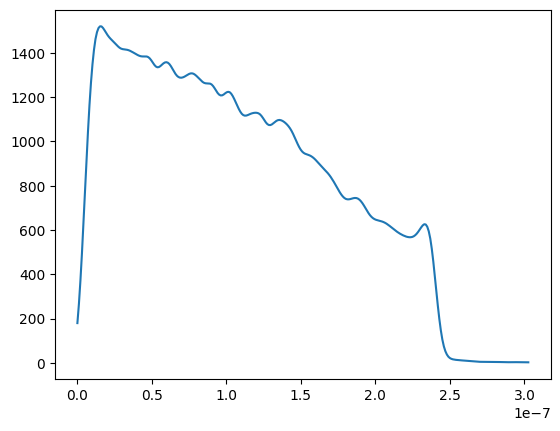

In [6]:
ss = np.linspace(i, 1, num=300) * df.loc[0, "slice_width"]
currents = df.loc[i, "slice_I"]

plt.plot(ss, currents)
plt.show()
